In [ ]:
# notebooks/colab.ipynb
# Cell 1: Setup and downloads
import os
# Change to the MILS_HW2 directory first
os.chdir('../MILS_HW2')

!pip install -r requirements.txt
# Download all datasets
!python scripts/download_imagenette_cls.py
!python scripts/download_coco_det.py
!python scripts/download_voc_seg.py

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Processing /rapids/aiohttp-3.8.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (from -r requirements.txt (line 4))
ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/rapids/aiohttp-3.8.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl'

Training subset size: 240
Validation subset size: 60
loading annotations into memory...


In [1]:
# Cell 2: Verify downloads
import os
# Change to the MILS_HW2 directory first
os.chdir('../MILS_HW2')

# Add a verification step
print("Verifying downloads...")
import torch
data_paths = {
    'seg': './data/VOCdevkit/VOC2012',
    'det': './data/coco_subset',
    'cls': './data/imagenette2-160'
}

for task, path in data_paths.items():
    if os.path.exists(path):
        print(f"{task} dataset found at {path}")
    else:
        print(f"WARNING: {task} dataset not found at {path}")
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Verifying downloads...
seg dataset found at ./data/VOCdevkit/VOC2012
det dataset found at ./data/coco_subset
cls dataset found at ./data/imagenette2-160
Using device: cuda


In [2]:
# Cell 3: Model and Data initialization 
from src.models.unified_model import UnifiedModel
from src.datasets.data_loaders import create_dataloaders
from src.training.loss_functions import MultiTaskLoss, UncertaintyWeightedLoss
from configs.config import Config  # 使用Config類

# 初始化配置
config = Config()  # 創建Config實例，不是模組

# 初始化損失函數
criterion = MultiTaskLoss()
print("Loss functions initialized")

# 初始化模型
model = UnifiedModel().to(device)
print(f"Total parameters: {sum(p.numel() for p in model.parameters())/1e6:.1f}M")

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params/1e6:.2f}M")
assert total_params <= 8e6, f"Parameter count {total_params/1e6:.2f}M exceeds 8M limit!"

# 創建數據載入器 (根據你的下載檔案)
print("Loading datasets...")
dataloaders = create_dataloaders(
    batch_size=config.batch_size,
    num_workers=config.num_workers
)
print("dataloaders", dataloaders)

# # 準備datasets字典給trainer使用 (只用train set)
# datasets = {
#     'seg': dataloaders['seg']['train'],
#     'seg_val': dataloaders['seg']['val'],
#     'det': dataloaders['det']['train'],
#     'det_val': dataloaders['det']['val'],
#     'cls': dataloaders['cls']['train'],
#     'cls_val': dataloaders['cls']['val']
# }
# print("datasets:\n", datasets)
# print("Datasets loaded successfully!")
# print(f"Detection batches: {len(datasets['det'])}")
# print(f"Segmentation batches: {len(datasets['seg'])}")
# print(f"Classification batches: {len(datasets['cls'])}")

Loss functions initialized


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total parameters: 3.2M
Total parameters: 3.15M
Loading datasets...
loading annotations into memory...
Done (t=10.47s)
creating index...
index created!
loading annotations into memory...
Done (t=1.19s)
creating index...
index created!
dataloaders {'seg': {'train': <torch.utils.data.dataloader.DataLoader object at 0x7fc7a5043040>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7fc7a5043220>}, 'cls': {'train': <torch.utils.data.dataloader.DataLoader object at 0x7fc7a5043ac0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7fc7a5043910>}, 'det': {'train': <torch.utils.data.dataloader.DataLoader object at 0x7fc7a5043640>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7fc7a5043250>}}


=== Stage 1: Segmentation Only ===
Stage 1: Training on Mini-VOC-Seg only...
[EVAL] Segmentation mIoU: 0.2115
Segmentation mIoU baseline: 0.2115
=== Stage 2: Detection Only ===
Stage 2: Training on Mini-COCO-Det with forgetting mitigation...
[EWC] Computing Fisher information for segmentation...
[Replay] Creating replay buffer...
[EVAL] Detection val batches processed: 60
[EVAL] Segmentation mIoU: 0.0477
Detection mAP baseline: 0.5000
Segmentation mIoU after detection: 0.0477 (drop 77.43%)
=== Stage 3: Classification Only ===
Stage 3: Training on Imagenette-160 with replay...
[Replay] Creating replay buffer...
[EVAL] Classification Top-1 Accuracy: 1.0000
[EVAL] Segmentation mIoU: 0.0624
[EVAL] Detection val batches processed: 60
[EVAL] Classification Top-1 Accuracy: 1.0000
Classification Top-1 baseline: 1.0000
Segmentation mIoU after classification: 0.0624 (drop 70.50%)
Detection mAP after classification: 0.5000 (drop 0.00%)
Classification Top-1 after classification: 1.0000 (drop 0.00%

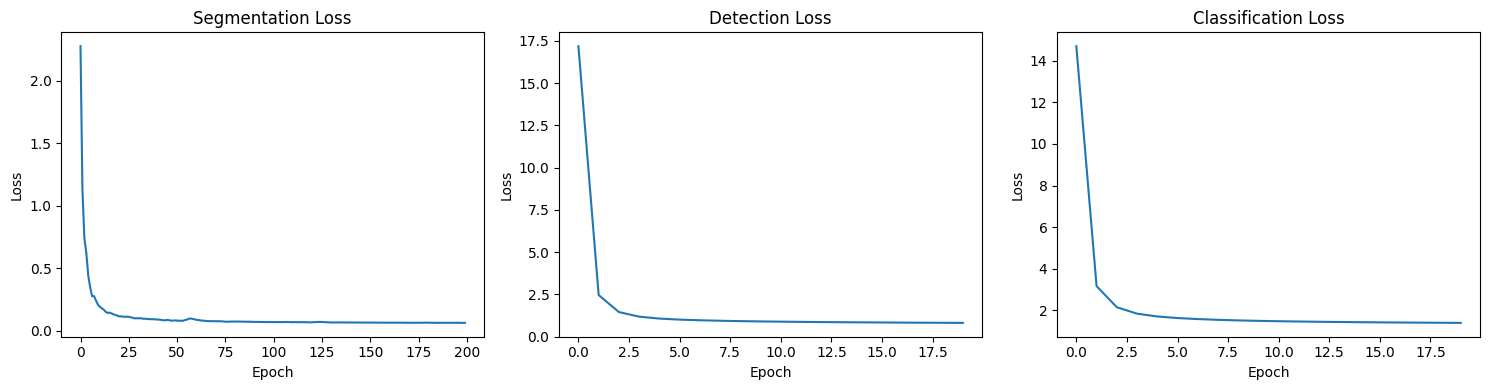

In [3]:
# Cell 4: Three-stage training
import time
import matplotlib.pyplot as plt
start_time = time.time()
from src.training.trainer import MultiTaskTrainer
trainer = MultiTaskTrainer(model, dataloaders, config)

# Stage 1: Segmentation baseline
print("=== Stage 1: Segmentation Only ===")
seg_result = trainer.train_stage_1_segmentation(epochs=200)
seg_baseline = seg_result['miou']
seg_losses = seg_result['losses']
print(f"Segmentation mIoU baseline: {seg_baseline:.4f}")

# Stage 2: Detection with EWC
print("=== Stage 2: Detection Only ===")
det_result = trainer.train_stage_2_detection(epochs=20)
det_baseline = det_result['map']
det_losses = det_result['losses']
seg_after_det = trainer.evaluate_segmentation()
seg_drop = (seg_baseline - seg_after_det) / seg_baseline * 100
print(f"Detection mAP baseline: {det_baseline:.4f}")
print(f"Segmentation mIoU after detection: {seg_after_det:.4f} ({'improvement' if seg_drop < 0 else 'drop'} {abs(seg_drop):.2f}%)")

# Stage 3: Classification with replay
print("=== Stage 3: Classification Only ===")
cls_result = trainer.train_stage_3_classification(epochs=20)
cls_baseline = cls_result['top1']
cls_losses = cls_result['losses']
seg_after_cls = trainer.evaluate_segmentation()
det_after_cls = trainer.evaluate_detection()
cls_after_cls = trainer.evaluate_classification()
seg_drop2 = (seg_baseline - seg_after_cls) / seg_baseline * 100
det_drop2 = (det_baseline - det_after_cls) / det_baseline * 100
cls_drop2 = (cls_baseline - cls_after_cls) / cls_baseline * 100
print(f"Classification Top-1 baseline: {cls_baseline:.4f}")
print(f"Segmentation mIoU after classification: {seg_after_cls:.4f} ({'improvement' if seg_drop2 < 0 else 'drop'} {abs(seg_drop2):.2f}%)")
print(f"Detection mAP after classification: {det_after_cls:.4f} ({'improvement' if det_drop2 < 0 else 'drop'} {abs(det_drop2):.2f}%)")
print(f"Classification Top-1 after classification: {cls_after_cls:.4f} ({'improvement' if cls_drop2 < 0 else 'drop'} {abs(cls_drop2):.2f}%)")

end_time = time.time()
elapsed = end_time - start_time
print(f"Total training time: {elapsed/60:.2f} minutes ({elapsed:.1f} seconds)")

# Plot loss curves
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(seg_losses)
plt.title('Segmentation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1,3,2)
plt.plot(det_losses)
plt.title('Detection Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1,3,3)
plt.plot(cls_losses)
plt.title('Classification Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()


In [4]:
# Cell 5: Final evaluation
# !python scripts/eval.py --weights checkpoints/final_model.pt --dataroot data --tasks all
model.eval()
dummy_input = torch.randn(1, 3, 512, 512).to(device)

# 預熱
for _ in range(10):
    with torch.no_grad():
        _ = model(dummy_input)

# 測試推理速度
start_time = time.time()
for _ in range(100):
    with torch.no_grad():
        outputs = model(dummy_input)
avg_time = (time.time() - start_time) / 100 * 1000  # ms

print(f"Average inference time: {avg_time:.2f}ms")
assert avg_time <= 150, f"Inference time {avg_time:.2f}ms exceeds 150ms limit!"

Average inference time: 5.10ms


In [5]:
# Cell 6: Saving results
import os
import json
from datetime import datetime

# Create a unique results directory
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results_dir = os.path.join('results', f'run_{timestamp}')
os.makedirs(results_dir, exist_ok=True)

# Save model
model_path = os.path.join(results_dir, 'final_model.pt')
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Collect all details for results
results = {
    'segmentation': {
        'baseline_miou': float(seg_baseline),
        'after_detection_miou': float(seg_after_det),
        'after_classification_miou': float(seg_after_cls),
        'drop_after_detection': float(seg_drop),
        'drop_after_classification': float(seg_drop2),
        'loss_curve': [float(x) for x in seg_losses]
    },
    'detection': {
        'baseline_map': float(det_baseline),
        'after_classification_map': float(det_after_cls),
        'drop_after_classification': float(det_drop2),
        'loss_curve': [float(x) for x in det_losses]
    },
    'classification': {
        'baseline_top1': float(cls_baseline),
        'after_classification_top1': float(cls_after_cls),
        'drop_after_classification': float(cls_drop2),
        'loss_curve': [float(x) for x in cls_losses]
    },
    'parameter_count': int(total_params),
    'inference_time_ms': float(avg_time),
    'training_time_sec': float(elapsed),
    'training_time_min': float(elapsed/60),
    'config': {
        'stage1_epochs': config.stage1_epochs,
        'stage2_epochs': config.stage2_epochs,
        'stage3_epochs': config.stage3_epochs,
        'batch_size': config.batch_size,
        'replay_size': config.replay_size,
        'ewc_lambda': config.ewc_lambda,
        'lr': config.lr
    },
    'timestamp': timestamp
}

# Save results
results_path = os.path.join(results_dir, 'results.json')
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)
print(f"Results saved to {results_path}")

Model saved to results/run_20250616_033547/final_model.pt
Results saved to results/run_20250616_033547/results.json
